In [0]:

import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import sklearn.preprocessing
import matplotlib
import zipfile
from PIL import Image

In [0]:
from google.colab import files
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sklearn.preprocessing as skl
from PIL import Image, ImageOps
from os import scandir, getcwd
from os import listdir
import os
from os.path import isfile, join
import zipfile                          # Per importació a partir de ZIP
import io

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [16]:
!wget "https://github.com/gdsa-upc/2019-Equip4/raw/master/TB2019.zip" -O Dades.zip

--2019-12-08 09:16:23--  https://github.com/gdsa-upc/2019-Equip4/raw/master/TB2019.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gdsa-upc/2019-Equip4/master/TB2019.zip [following]
--2019-12-08 09:16:23--  https://raw.githubusercontent.com/gdsa-upc/2019-Equip4/master/TB2019.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98472 (96K) [application/zip]
Saving to: ‘Dades.zip’

Dades.zip           100%[===================>]  96.16K  --.-KB/s    in 0.01s   

2019-12-08 09:16:23 (8.90 MB/s) - ‘Dades.zip’ saved [98472/98472]



In [0]:
f = zipfile.ZipFile("Dades.zip",'r')
for file in f.namelist():
    f.extract(file,"./Dades/")  # Guardar en el directori /Dades/
f.close()

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
        'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data_dir = "/root/Dades/tb2108/tb2108"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [0]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [0]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

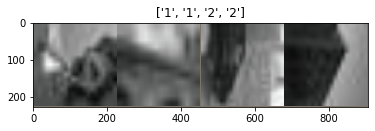

In [36]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [39]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 68.1MB/s]


In [40]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6848 Acc: 0.6056
val Loss: 0.9351 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.6585 Acc: 0.6901
val Loss: 0.3787 Acc: 0.7679

Epoch 2/24
----------
train Loss: 0.6201 Acc: 0.6620
val Loss: 0.4485 Acc: 0.8214

Epoch 3/24
----------
train Loss: 0.8182 Acc: 0.5775
val Loss: 0.3997 Acc: 0.8036

Epoch 4/24
----------
train Loss: 0.5964 Acc: 0.6901
val Loss: 0.3599 Acc: 0.8393

Epoch 5/24
----------
train Loss: 0.4659 Acc: 0.8169
val Loss: 0.2673 Acc: 0.9286

Epoch 6/24
----------
train Loss: 0.6784 Acc: 0.7183
val Loss: 0.5703 Acc: 0.7679

Epoch 7/24
----------
train Loss: 0.4689 Acc: 0.7887
val Loss: 0.2718 Acc: 0.9107

Epoch 8/24
----------
train Loss: 0.5725 Acc: 0.7042
val Loss: 0.2505 Acc: 0.8750

Epoch 9/24
----------
train Loss: 0.5491 Acc: 0.7183
val Loss: 0.2226 Acc: 0.9107

Epoch 10/24
----------
train Loss: 0.4375 Acc: 0.7606
val Loss: 0.2877 Acc: 0.8750

Epoch 11/24
----------
train Loss: 0.2841 Acc: 0.8873
val Loss: 0.2232 Acc: 0.9107

Ep

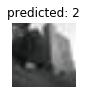

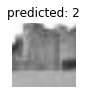

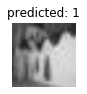

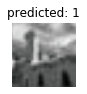

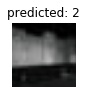

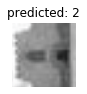

In [41]:
visualize_model(model_ft)

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [0]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

In [0]:
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [45]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8298 Acc: 0.5634
val Loss: 0.9514 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.7065 Acc: 0.5915
val Loss: 0.5229 Acc: 0.8393

Epoch 2/24
----------
train Loss: 0.6847 Acc: 0.6479
val Loss: 0.4615 Acc: 0.8036

Epoch 3/24
----------
train Loss: 0.5836 Acc: 0.6901
val Loss: 0.6681 Acc: 0.5714

Epoch 4/24
----------
train Loss: 0.8589 Acc: 0.5634
val Loss: 0.7124 Acc: 0.5893

Epoch 5/24
----------
train Loss: 0.8892 Acc: 0.6197
val Loss: 1.0532 Acc: 0.5000

Epoch 6/24
----------
train Loss: 0.6669 Acc: 0.6620
val Loss: 0.5493 Acc: 0.6964

Epoch 7/24
----------
train Loss: 0.6477 Acc: 0.6479
val Loss: 0.3887 Acc: 0.8393

Epoch 8/24
----------
train Loss: 0.4688 Acc: 0.7746
val Loss: 0.3939 Acc: 0.8571

Epoch 9/24
----------
train Loss: 0.4666 Acc: 0.7324
val Loss: 0.3977 Acc: 0.8214

Epoch 10/24
----------
train Loss: 0.5570 Acc: 0.6620
val Loss: 0.4069 Acc: 0.8929

Epoch 11/24
----------
train Loss: 0.5103 Acc: 0.7465
val Loss: 0.4419 Acc: 0.8571

Ep

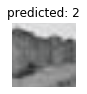

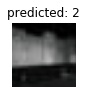

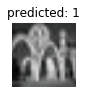

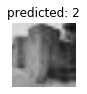

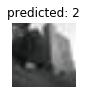

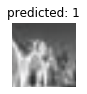

In [46]:
visualize_model(model_conv)

plt.ioff()
plt.show()